In [1]:
from typing import List, Dict
import os
import subprocess
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def parse_sim_results(simfile: str, cols: List[str]):
    data = {}
    df = pd.read_csv(simfile)
    for col in cols:
        data[col] = df[col].values
    return data

def parse_dirname(dirname: str):
    data = {}
    tokens = dirname.split('/')[-1].split('_')
    data['sample'] = tokens[2]
    for t in tokens[3:]:
        k,v = t.split('=')
        data[k] = v
    return data
    

def pade_approx(times: np.ndarray, 
                D0: float, 
                svp: float, 
                tort_limit: float, 
                tort_time: float) -> np.ndarray:
    ''' 
    This function returns a Padé approximation of the diffusivity function
    '''
    term_a = (1.0 - tort_limit)
    term_b = ((4.0 * np.sqrt(D0)) / (9.0 * np.pi)) * svp
    term_sqrt = term_b * np.sqrt(times)
    term_linear = term_a * (D0/(D0*tort_time)) * times
    term_div = term_a + term_sqrt + term_linear
    return (1.0 - term_a * (term_sqrt + term_linear) / term_div)

def fit_pade_params(times: np.ndarray, 
                    ydata: np.ndarray, 
                    D0: float, 
                    bounds: List[List] = None, 
                    refac: bool = False) -> Dict:
    '''
    This functions returns Padé aproximation params for diffusivity curve
    '''
    fitting_bounds = [[0.999999*D0], [D0]]
    if(bounds):
        fitting_bounds[0].extend(bounds[0])
        fitting_bounds[1].extend(bounds[1])
    else:
        fitting_bounds[0].extend([0.0, 0.0, 0.0])
        fitting_bounds[1].extend([np.inf, 1.0, np.inf])
        
    popt, pcov = curve_fit(pade_approx, times, ydata, bounds=tuple(fitting_bounds))
    if(refac):
        r = 3.0 / popt[1]
        theta_min = r**2 / D0
        theta_max = (10.0 * r)**2 / D0
        fitting_bounds[0][3] = theta_min
        fitting_bounds[1][3] = theta_max
        popt, pcov = curve_fit(pade_approx, times, ydata, bounds=tuple(fitting_bounds))
    
    params = {
        'D0': popt[0],
        'SVp': popt[1],
        'tort_limit': popt[2],
        'theta': popt[3],
        'popt': popt,
        'pcov': pcov
    }
    return params

In [7]:
litotype = 'carbonates'

protocol = {
    'sandstones': '3',
    'carbonates': '2'
}

In [8]:
# RESULTS
EXP_FILE = os.path.join(os.getcwd(), 'datasets', f"{litotype}_experimental_data.csv")
FEM_FILE = os.path.join(os.getcwd(), 'datasets', 'fem_data', 'fem_results.csv')
DB_DIR = os.path.join(os.getcwd(), 'db', f"{litotype}_protocol{protocol[litotype]}")
SIM_DIRS = [os.path.join(DB_DIR, sd) for sd in sorted(os.listdir(DB_DIR))]
D0 = 2.5
PADE_BOUNDS = [[0.0, 0.0, 0.0], [np.inf, 1.0, np.inf]]
df_msd = None
df_sat = None
CSV_DESTINATION_PATH = os.path.join(os.getcwd(), 'dataset', f"{litotype}.csv") 

for i,s in enumerate(SIM_DIRS):
    info = parse_dirname(s)
    pfg_dir = [d for d in os.listdir(s) if 'NMR_pfgse' in d]
    file = os.path.join(s, pfg_dir[0], 'PFGSE_results.csv')
    data = parse_sim_results(file, ['Time','DmsdZ','Dsat'])
    pade_fit_msd = fit_pade_params(data['Time'], (1.0/D0)*data['DmsdZ'], D0, PADE_BOUNDS, refac=False)
#     pade_fit_sat = fit_pade_params(data['Time'], (1.0/D0)*data['Dsat'], D0, PADE_BOUNDS, refac=False)
    
#     Save results in pandas DataFrame
#     if i == 0, create empty DataFrame
    if(i == 0):
        info_cols = ['sample']
        time_cols = [f"Dt_{t:.2f}ms" for t in data['Time']]
        fit_cols = ['svp', 'tortuosity', 'theta']
        df_cols = info_cols + time_cols + fit_cols
        df_msd = pd.DataFrame(columns = df_cols)
#         df_sat = pd.DataFrame(columns = df_cols)
        
    new_row = [info['sample']]
    new_row += [dt/D0 for dt in data['DmsdZ']]
    new_row += [pade_fit_msd['SVp'], 1.0/pade_fit_msd['tort_limit'], pade_fit_msd['theta']]
    df_msd.loc[i] = new_row
    
#     new_row = [info['sample'], float(info['mfilter'])]
#     new_row += [dt/D0 for dt in data['Dsat']]
#     new_row += [pade_fit_sat['SVp'], 1.0/pade_fit_sat['tort_limit'], pade_fit_sat['theta']]
#     df_sat.loc[i] = new_row
    

In [9]:
df_msd

,sample,Dt_10.00ms,Dt_60.41ms,Dt_110.81ms,Dt_161.22ms,Dt_211.62ms,Dt_262.02ms,Dt_312.43ms,Dt_362.83ms,Dt_413.23ms,...,Dt_4697.58ms,Dt_4747.98ms,Dt_4798.39ms,Dt_4848.79ms,Dt_4899.20ms,Dt_4949.60ms,Dt_5000.00ms,svp,tortuosity,theta
0,AC,0.486563,0.351983,0.311110,0.286103,0.267299,0.253317,0.241069,0.232993,0.225479,...,0.115080,0.114738,0.114586,0.114259,0.113909,0.113825,0.113611,1.191511,12.629376,1.940040e+06
1,DP,0.611639,0.492328,0.456148,0.431921,0.414111,0.401996,0.390842,0.384164,0.377015,...,0.266926,0.266674,0.266445,0.266003,0.265501,0.264938,0.264228,0.778896,4.439015,1.716202e+06
2,EW,0.675027,0.543666,0.486819,0.455513,0.430567,0.411875,0.395751,0.382427,0.367894,...,0.161074,0.160790,0.160184,0.159435,0.158941,0.158309,0.157796,0.436699,20.539490,4.760856e+06
3,IH,0.731992,0.622245,0.580059,0.554306,0.533946,0.515077,0.502573,0.490215,0.477140,...,0.252113,0.251347,0.249921,0.248418,0.247595,0.247140,0.246183,0.293119,8.310811,5.345611e+06
4,IL,0.773579,0.653215,0.604884,0.570206,0.546318,0.529696,0.512545,0.499449,0.490429,...,0.265868,0.265160,0.264908,0.263465,0.262534,0.261762,0.261180,0.273645,8.162447,6.901229e+06
5,IM,0.481800,0.344468,0.305109,0.282647,0.264849,0.253111,0.242909,0.233922,0.226282,...,0.099211,0.098747,0.098149,0.097503,0.097190,0.096811,0.096478,1.115308,16.176191,1.014261e+06
6,LU,0.602561,0.444580,0.399264,0.371665,0.353569,0.339473,0.329501,0.319173,0.309756,...,0.182622,0.182306,0.182078,0.181547,0.180572,0.179682,0.179029,0.797546,7.526067,3.324025e+06
7,SD,0.845721,0.736885,0.691290,0.662680,0.640311,0.622278,0.609584,0.597557,0.585564,...,0.383038,0.382393,0.381754,0.380571,0.379032,0.378114,0.377338,0.202969,4.202421,7.563955e+06


<IPython.core.display.Javascript object>


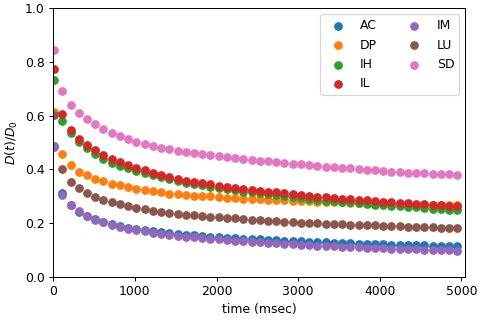

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,4),constrained_layout=True)
to_be_removed = ['EW']

for index, row in df_msd.iterrows():
    if(row['sample'] not in to_be_removed):
        axs.scatter(data['Time'][::2], row.iloc[1:-3].values[::2], label=f"{row['sample']}")

axs.set_ylim([0,1])
axs.set_xlim([0,1.01*data['Time'].max()])
axs.set_xlabel('time (msec)')
axs.set_ylabel(r'$D(t)/D_0$')
axs.legend(loc='best', ncol=2)

In [11]:
plt.savefig(fname=f"figs/Dt_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/Dt_{litotype}.png", format="png")

In [12]:
plt.close('all')

In [13]:
df_experimental = pd.read_csv(EXP_FILE)
df_experimental

,sample,tag,porosity_he,permeability_he,grain_density,cementation,T2_logmean,rho2
0,Austin Chalk,AC,23.0,9.99,2.70,2.03,27.2,23.3
1,Desert Pink,DP,30.5,95.50,2.71,2.40,100.9,12.3
2,Edwards Yellow,EY,22.9,165.00,2.61,2.39,299.9,10.5
3,Guelph Dolomite,GD,7.9,4.27,2.84,1.71,173.5,12.4
4,Indiana 8-10 mD,IL,9.1,0.42,2.69,1.52,89.0,4.9
5,Indiana 2-4 mD,IM,13.8,1.97,2.70,1.74,179.6,3.3
6,Indiana 70 mD,IH,18.9,301.00,2.69,2.10,66.8,35.8
7,Leuders,LU,16.2,1.03,2.73,1.69,39.4,10.5
8,Sillurian Dolomite,SD,12.4,18.30,2.86,1.95,212.8,9.5
9,Wiscosin,WI,5.6,0.75,2.81,1.42,71.1,11.8


In [14]:
df_fem = pd.read_csv(FEM_FILE)
df_fem

,sample,rock_type,voxels_x,voxels_y,voxels_z,resolution,porosity,kx,ky,kz,kavg,kharm
0,AC,carbonate,600,600,600,1.0,0.1317,16.281987,19.429186,19.265769,18.325647,18.204761
1,DP,carbonate,600,600,600,0.9,0.3101,110.582197,116.227972,108.049050,111.619740,111.516354
2,EW,carbonate,600,600,600,1.0,0.3150,75.563585,69.951679,70.680895,72.065386,71.981172
3,IH,carbonate,600,600,600,1.5,0.0309,13.718306,10.042881,24.365349,16.042179,14.050850
4,IL,carbonate,600,600,600,2.0,0.0521,31.523786,33.884999,35.242968,33.550584,33.479110
5,IM,carbonate,600,600,600,2.0,0.0377,15.182707,15.155454,14.315427,14.884529,14.873430
6,LU,carbonate,600,600,600,2.0,0.0534,26.895539,26.599144,25.550322,26.348335,26.335534
7,SD,carbonate,600,600,600,2.0,0.1521,555.679922,113.508618,124.805406,264.664649,161.099997
8,BB,sandstone,600,600,600,2.0,0.1215,75.003159,71.657452,63.376609,70.012407,69.659314
9,BG,sandstone,600,600,600,2.0,0.1282,71.695964,75.933004,69.169460,72.266143,72.159551


In [15]:
df_merged = df_msd.merge(df_experimental, left_on="sample", right_on="tag")[["sample_x", "svp", "tortuosity", "permeability_he"]]
df_merged

,sample_x,svp,tortuosity,permeability_he
0,AC,1.191511,12.629376,9.99
1,DP,0.778896,4.439015,95.50
2,EW,0.436699,20.539490,2.22
3,IH,0.293119,8.310811,301.00
4,IL,0.273645,8.162447,0.42
5,IM,1.115308,16.176191,1.97
6,LU,0.797546,7.526067,1.03
7,SD,0.202969,4.202421,18.30


In [16]:
df_final = df_merged.merge(df_fem, left_on="sample_x", right_on="sample")[["sample", "svp", "tortuosity", "permeability_he", "kz"]]
df_final = df_final[~df_final['sample'].isin(to_be_removed)]
df_final

,sample,svp,tortuosity,permeability_he,kz
0,AC,1.191511,12.629376,9.99,19.265769
1,DP,0.778896,4.439015,95.50,108.049050
3,IH,0.293119,8.310811,301.00,24.365349
4,IL,0.273645,8.162447,0.42,35.242968
5,IM,1.115308,16.176191,1.97,14.315427
6,LU,0.797546,7.526067,1.03,25.550322
7,SD,0.202969,4.202421,18.30,124.805406


In [17]:
torts = df_final.tortuosity.values
svps = df_final.svp.values
perms = df_final.permeability_he.values
perms_fem = df_final.kz.values
samples = df_final['sample'].values

<IPython.core.display.Javascript object>


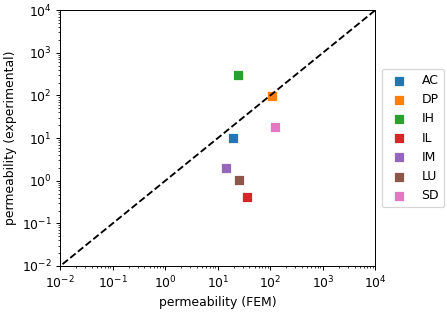

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,3.5),constrained_layout=True)

for index, sample in enumerate(samples):
    if(sample not in to_be_removed):
        axs.scatter([perms_fem[index]], [perms[index]], marker="s", label=f"{sample}")

axs.plot([0,1e6],[0,1e6],linestyle="dashed",color="k")
        
axs.set_yscale('log')
axs.set_ylabel(r'permeability (experimental)')
axs.set_ylim([1e-2,1e4])
axs.set_xscale('log')
axs.set_xlabel(r'permeability (FEM)')
axs.set_xlim([1e-2,1e4])  
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

In [19]:
plt.savefig(fname=f"figs/perms_correlation_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/perms_correlation_{litotype}.png", format="png")

In [20]:
plt.close('all')

<IPython.core.display.Javascript object>


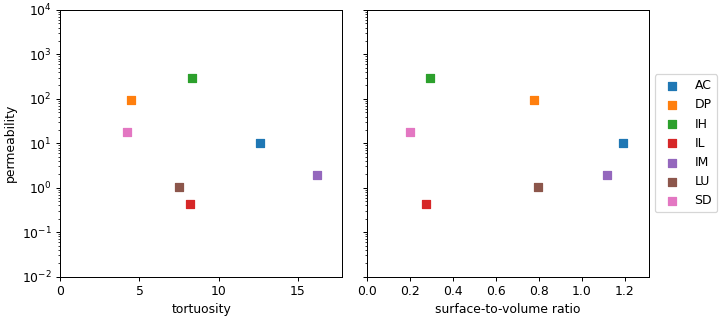

(0.0, 1.3106624299744312)

In [21]:
fig, axs = plt.subplots(1,2,figsize=(9,4),constrained_layout=True)

for index, sample in enumerate(samples):
    if(sample not in to_be_removed):
        axs[0].scatter([torts[index]], [perms[index]], marker="s", label=f"{sample}")
        axs[1].scatter([svps[index]], [perms[index]], marker="s", label=f"{sample}")

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylabel(r'permeability')
    ax.set_ylim([1e-2,1e4])
    ax.label_outer()
    
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
axs[0].set_xlabel('tortuosity')
axs[0].set_xlim([0,1.1*torts.max()])

axs[1].set_xlabel('surface-to-volume ratio')
axs[1].set_xlim([0,1.1*svps.max()])


In [22]:
plt.savefig(fname=f"figs/exp_perms_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/exp_perms_{litotype}.png", format="png")

In [23]:
plt.close('all')

<IPython.core.display.Javascript object>


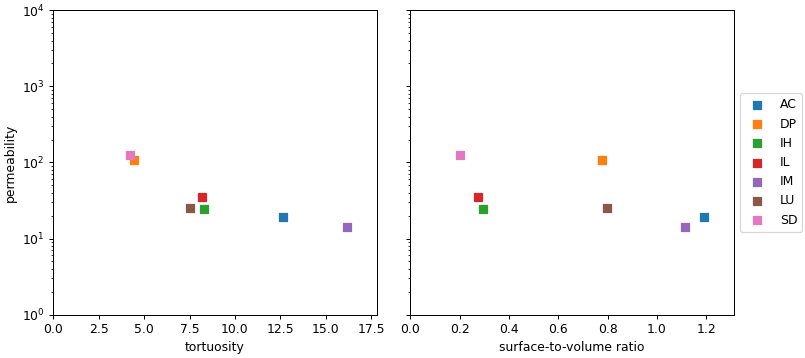

(0.0, 1.3106624299744312)

In [24]:
fig, axs = plt.subplots(1,2,figsize=(9,4),constrained_layout=True)

for index, sample in enumerate(samples):
    if(sample not in to_be_removed):
        axs[0].scatter([torts[index]], [perms_fem[index]], marker="s", label=f"{sample}")
        axs[1].scatter([svps[index]], [perms_fem[index]], marker="s", label=f"{sample}")

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylabel(r'permeability')
    ax.set_ylim([1e0,1e4])
    ax.label_outer()
    
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
axs[0].set_xlabel('tortuosity')
axs[0].set_xlim([0,1.1*torts.max()])

axs[1].set_xlabel('surface-to-volume ratio')
axs[1].set_xlim([0,1.1*svps.max()])


In [25]:
plt.savefig(fname=f"figs/fem_perms_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/fem_perms_{litotype}.png", format="png")

In [26]:
plt.close('all')